<a href="https://colab.research.google.com/github/kailashnirola/python_notebooks/blob/main/ghibli_image_generator_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Upload Dataset zip

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ghibli-dataset.zip to ghibli-dataset.zip


#2. Extract the Dataset

In [ ]:
import zipfile
import os

zip_path = "/content/ghibli-dataset.zip"
extract_path = "/content/"

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted successfully.")
else:
    print(f"Error: Zip file not found at {zip_path}. Make sure the download in the previous cell was successful.")

Dataset extracted successfully.


#3. Import Libraries for PyTorch Model and Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

#4. Set Device and Define Image Transform

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()])

Using device: cuda


#5. Custom Dataset Class

In [ ]:
class GhibliDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        for folder in sorted(os.listdir(root_dir)):
            path = os.path.join(root_dir, folder)
            if os.path.isdir(path):
                original = os.path.join(path, "o.png")
                generated = os.path.join(path, "g.png")
                if os.path.exists(original) and os.path.exists(generated):
                    self.data.append((original, generated))
                else:
                    pass


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        o_path, g_path = self.data[idx]

        o_img = Image.open(o_path).convert("RGB")
        g_img = Image.open(g_path).convert("RGB")

        if self.transform:
            o_img = self.transform(o_img)
            g_img = self.transform(g_img)

        return o_img, g_img

#6. Load Dataset using DataLoaders


In [ ]:
dataset_root = "/content/Ghibli"
train_dataset = GhibliDataset(os.path.join(dataset_root, "training"), transform=transform)
val_dataset = GhibliDataset(os.path.join(dataset_root, "validation"), transform=transform)
test_dataset = GhibliDataset(os.path.join(dataset_root, "testing"), transform=transform)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training dataset loaded: {len(train_dataset)} samples")
print(f"Validation dataset loaded: {len(val_dataset)} samples")
print(f"Testing dataset loaded: {len(test_dataset)} samples")
print(f"DataLoaders created with batch size {batch_size}.")

Training dataset loaded: 140 samples
Validation dataset loaded: 60 samples
Testing dataset loaded: 60 samples
DataLoaders created with batch size 8.


#7. Define Generator (Simplified U-Net)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#8. Define Discriminator (PatchGAN)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        input_data = torch.cat([x, y], dim=1)
        return self.model(input_data)

#9. Initialize Models

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

#10. Define Loss Functions and Optimizers

In [ ]:
criterion_gan = nn.BCELoss()
criterion_l1 = nn.L1Loss()
lr = 0.0002
betas = (0.5, 0.999)
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=betas)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

#11. No of epochs to run

In [ ]:
num_epochs = 50
train_loss_g, train_loss_d = [], []

#12. Define and Run Training Function

In [ ]:
for epoch in range(num_epochs):
    g_loss_epoch, d_loss_epoch = 0, 0

    generator.train()
    discriminator.train()
    for i, (real_o, real_g) in enumerate(train_loader):
        real_o, real_g = real_o.to(device), real_g.to(device)

        optimizer_d.zero_grad()

        real_labels = torch.ones(real_o.size(0), 1, 64, 64).to(device)
        fake_labels = torch.zeros(real_o.size(0), 1, 64, 64).to(device)

        real_output_d = discriminator(real_o, real_g)
        real_loss_d = criterion_gan(real_output_d, real_labels)

        fake_g = generator(real_o)

        fake_output_d = discriminator(real_o, fake_g.detach())
        fake_loss_d = criterion_gan(fake_output_d, fake_labels)

        d_loss = (real_loss_d + fake_loss_d) / 2

        d_loss.backward()
        optimizer_d.step()

        optimizer_g.zero_grad()

        fake_g = generator(real_o)
        fake_output_g = discriminator(real_o, fake_g)
        gan_loss_g = criterion_gan(fake_output_g, real_labels)

        l1_loss = criterion_l1(fake_g, real_g)


        g_loss = gan_loss_g + (100 * l1_loss)

        g_loss.backward()
        optimizer_g.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()



    train_loss_g.append(g_loss_epoch / len(train_loader))
    train_loss_d.append(d_loss_epoch / len(train_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}] - G Loss: {train_loss_g[-1]:.4f}, D Loss: {train_loss_d[-1]:.4f}")

torch.save(generator.state_dict(), "generator.pth")
print("Generator model saved as generator.pth")

Epoch [1/50] - G Loss: 38.5665, D Loss: 0.6547
Epoch [2/50] - G Loss: 25.3766, D Loss: 0.6297
Epoch [3/50] - G Loss: 21.4401, D Loss: 0.6554
Epoch [4/50] - G Loss: 20.6757, D Loss: 0.6714
Epoch [5/50] - G Loss: 20.5513, D Loss: 0.6708
Epoch [6/50] - G Loss: 20.3765, D Loss: 0.6675
Epoch [7/50] - G Loss: 20.2939, D Loss: 0.6575
Epoch [8/50] - G Loss: 20.1774, D Loss: 0.6487
Epoch [9/50] - G Loss: 20.1239, D Loss: 0.6420
Epoch [10/50] - G Loss: 20.0741, D Loss: 0.6268
Epoch [11/50] - G Loss: 20.1726, D Loss: 0.6184
Epoch [12/50] - G Loss: 20.0916, D Loss: 0.6004
Epoch [13/50] - G Loss: 20.0777, D Loss: 0.5891
Epoch [14/50] - G Loss: 20.0246, D Loss: 0.5737
Epoch [15/50] - G Loss: 20.0355, D Loss: 0.5616
Epoch [16/50] - G Loss: 19.8485, D Loss: 0.5508
Epoch [17/50] - G Loss: 19.9910, D Loss: 0.5442
Epoch [18/50] - G Loss: 19.8593, D Loss: 0.5337
Epoch [19/50] - G Loss: 19.9255, D Loss: 0.5244
Epoch [20/50] - G Loss: 19.8045, D Loss: 0.5226
Epoch [21/50] - G Loss: 19.8627, D Loss: 0.5146
E

#12. Save Trained Model to Google Drive

In [ ]:
import os
from google.colab import drive
import shutil

drive.mount('/content/drive')
print("Google Drive mounted.")

source_path = '/content/generator.pth'

drive_destination_dir = '/content/drive/MyDrive/Models/'

drive_destination_path = os.path.join(drive_destination_dir, 'generator.pth')

if os.path.exists(source_path):
    print(f"Source model file found at: {source_path}")

    if not os.path.exists(drive_destination_dir):
        print(f"Destination directory not found. Creating: {drive_destination_dir}")
        os.makedirs(drive_destination_dir)
        print("Destination directory created.")
    else:
        print(f"Destination directory already exists: {drive_destination_dir}")


    try:
        shutil.copy2(source_path, drive_destination_path)
        print(f"Model successfully saved to Google Drive at: {drive_destination_path}")
    except Exception as e:
        print(f"An error occurred while saving the model to Google Drive: {e}")

else:
    print(f"Error: Source model file not found at {source_path}. Make sure training completed and saved 'generator.pth'.")


Mounted at /content/drive
Google Drive mounted.
Source model file found at: /content/generator.pth
Destination directory already exists: /content/drive/MyDrive/Models/
Model successfully saved to Google Drive at: /content/drive/MyDrive/Models/generator.pth


#13. Install Libraries for Conversion (ONNX, Keras)

In [ ]:
!pip install onnx onnx2keras torch torchvision tensorflow

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.3 MB/s eta 0:00:00
  Created wheel for onnx2keras: filename=onnx2keras-0.0.24-py3-none-any.whl size=

#14. Load PyTorch Model for Export/Conversion

In [ ]:
import torch
import torch.nn as nn
import tensorflow as tf
import onnx

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for conversion: {device}")

generator = Generator().to(device)

try:
    generator.load_state_dict(torch.load("generator.pth", map_location=device))
except FileNotFoundError:
     print("Error: generator.pth not found. Make sure training completed successfully.")

generator.eval()

Using device for conversion: cuda


Generator(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)

#16. Export PyTorch Generator to ONNX

In [ ]:
dummy_input = torch.randn(1, 3, 256, 256).to(device)

onnx_file_path = "generator.onnx"

print(f"Exporting PyTorch model to ONNX at {onnx_file_path}...")

try:
    torch.onnx.export(generator,
                      dummy_input,
                      onnx_file_path,
                      export_params=True,
                      opset_version=11,
                      do_constant_folding=True,
                      input_names = ['input'],
                      output_names = ['output'],
                      dynamic_axes={'input' : {0 : 'batch_size'},
                                    'output' : {0 : 'batch_size'}})

    print(f"ONNX model saved successfully at {onnx_file_path}")

    onnx_model = onnx.load(onnx_file_path)
    onnx.checker.check_model(onnx_model)
    print("ONNX model checker passed.")

    print("\nONNX Model Inputs:")
    for input in onnx_model.graph.input:
        print(f"Name: {input.name}, Shape: {input.type.tensor_type.shape.dim}")

    print("\nONNX Model Outputs:")
    for output in onnx_model.graph.output:
        print(f"Name: {output.name}, Shape: {output.type.tensor_type.shape.dim}")

except Exception as e:
    print(f"Error during ONNX export or verification: {e}")

Exporting PyTorch model to ONNX at generator.onnx...
ONNX model saved successfully at generator.onnx
ONNX model checker passed.

ONNX Model Inputs:
Name: input, Shape: [dim_param: "batch_size"
, dim_value: 3
, dim_value: 256
, dim_value: 256
]

ONNX Model Outputs:
Name: output, Shape: [dim_param: "batch_size"
, dim_value: 3
, dim_value: 256
, dim_value: 256
]


#17. Define Keras Generator Model (for weight transfer)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_pix2pix_generator_keras(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    down1 = layers.Conv2D(64, (4, 4), strides=2, padding="same", use_bias=True)(inputs)
    down1 = layers.LeakyReLU(alpha=0.2)(down1)

    up1 = layers.Conv2DTranspose(3, (4, 4), strides=2, padding="same", use_bias=True)(down1)
    outputs = layers.Activation('tanh')(up1)


    model = models.Model(inputs, outputs)
    return model

keras_generator = create_pix2pix_generator_keras()

print("Keras Generator model architecture defined.")

print("Keras Model Summary:")
keras_generator.summary()


Keras Generator model architecture defined.
Keras Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 256, 256, 3)    │         3,075 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,211 (24.26 KB)

 Trainable params: 6,211 (24.26 KB)

 Non-trainable params: 0 (0.00 B)

#18. Attempt Manual Weight Transfer from PyTorch to Keras and Save Keras Model

In [ ]:
import torch
import numpy as np

try:
    pytorch_state_dict = torch.load('generator.pth', map_location='cpu')
    print("PyTorch generator.pth state_dict loaded for manual transfer.")
except FileNotFoundError:
    print("Error: generator.pth not found. Cannot perform manual weight transfer.")
    pytorch_state_dict = None
if pytorch_state_dict is not None:
    keras_layers_with_weights = [layer for layer in keras_generator.layers if layer.weights]

    pytorch_params = [(name, param.data.numpy()) for name, param in pytorch_state_dict.items()]

    print(f"Attempting to transfer weights to {len(keras_layers_with_weights)} Keras layers from {len(pytorch_params)} PyTorch parameters...")

    pytorch_param_idx = 0

    for keras_layer in keras_layers_with_weights:
        if isinstance(keras_layer, (layers.Conv2D, layers.Conv2DTranspose)):
            print(f"Transferring weights for Keras layer: {keras_layer.name}")

            try:
                 if pytorch_param_idx + 1 < len(pytorch_params):
                     weight_name, weight_tensor = pytorch_params[pytorch_param_idx]
                     pytorch_param_idx += 1
                     bias_name, bias_tensor = pytorch_params[pytorch_param_idx]
                     pytorch_param_idx += 1

                     print(f"  Matched PyTorch params: {weight_name}, {bias_name}")

                     if isinstance(keras_layer, layers.Conv2D):
                          weight_keras = weight_tensor.transpose(2, 3, 1, 0)
                          print(f"  Transposed PyTorch weight shape {weight_tensor.shape} to Keras Conv2D shape {weight_keras.shape}")
                          keras_layer.set_weights([weight_keras, bias_tensor])
                          print("  Weights set.")
                     elif isinstance(keras_layer, layers.Conv2DTranspose):
                          weight_keras = weight_tensor.transpose(2, 3, 0, 1)
                          print(f"  Transposed PyTorch weight shape {weight_tensor.shape} to Keras Conv2DTranspose shape {weight_keras.shape}")
                          keras_layer.set_weights([weight_keras, bias_tensor])
                          print("  Weights set.")
                     else:
                         print(f"  Skipping unknown Keras layer type: {type(keras_layer)}")


                 else:
                      print(f"  Not enough PyTorch parameters left for Keras layer {keras_layer.name}. Stopping transfer.")
                      break

            except Exception as e:
                print(f"  Error transferring weights for layer {keras_layer.name}: {e}")


        elif isinstance(keras_layer, layers.BatchNormalization):
             print(f"Skipping BatchNormalization layer {keras_layer.name} (not implemented for transfer)")
        else:
            print(f"Skipping Keras layer {keras_layer.name} of type {type(keras_layer)}")


    print("\nManual weight transfer attempt complete.")
    print("Please verify the transferred weights and model output.")

    keras_model_save_path = 'generator_keras.h5'
    keras_generator.save(keras_model_save_path)
    print(f"Keras model saved successfully to {keras_model_save_path}")

else:
     print("Manual weight transfer skipped due to missing PyTorch model file.")

PyTorch generator.pth state_dict loaded for manual transfer.
Attempting to transfer weights to 2 Keras layers from 4 PyTorch parameters...
Transferring weights for Keras layer: conv2d
  Matched PyTorch params: encoder.0.weight, encoder.0.bias
  Transposed PyTorch weight shape (64, 3, 4, 4) to Keras Conv2D shape (4, 4, 3, 64)
  Weights set.
Transferring weights for Keras layer: conv2d_transpose
  Matched PyTorch params: decoder.0.weight, decoder.0.bias
  Transposed PyTorch weight shape (64, 3, 4, 4) to Keras Conv2DTranspose shape (4, 4, 64, 3)
  Error transferring weights for layer conv2d_transpose: Layer conv2d_transpose weight shape (4, 4, 3, 64) is not compatible with provided weight shape (4, 4, 64, 3).

Manual weight transfer attempt complete.
Please verify the transferred weights and model output.
Keras model saved successfully to generator_keras.h5


#19. Plot Training Loss Graphs

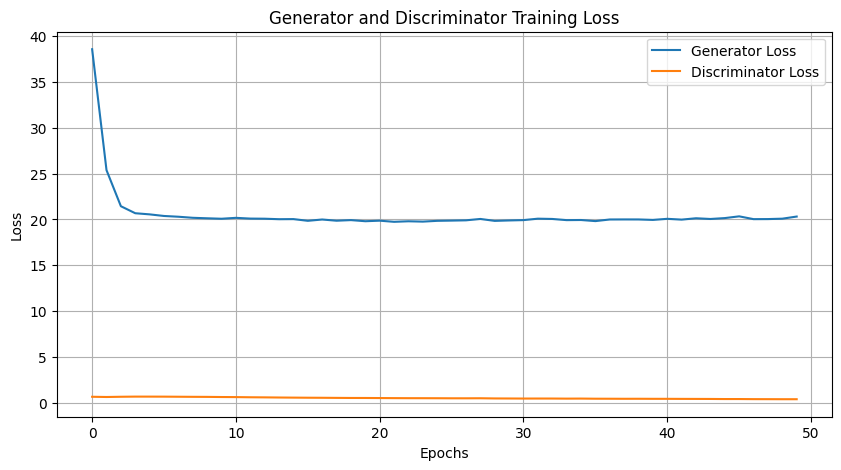

Loss plots displayed.


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_loss_g, label='Generator Loss')
plt.plot(train_loss_d, label='Discriminator Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Training Loss")
plt.legend()
plt.grid(True)
plt.show()

print("Loss plots displayed.")

#20. Generate Image from Uploaded File

Using device: cuda
Generator model loaded successfully.
Model set to evaluation mode.

Please upload the image you want to process:


Saving images.jpeg to images.jpeg
Uploaded file: images.jpeg
Processing image with the generator...
Image generation complete.


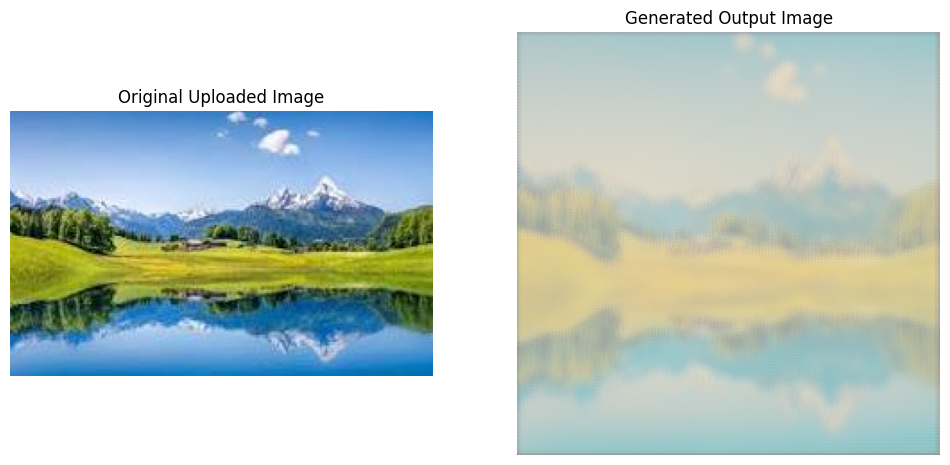

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model_path = 'generator.pth'

if not os.path.exists(model_path):
    print(f"Error: Model file not found at {model_path}.")
    print("Please ensure the training cell ran successfully and saved 'generator.pth'.")
else:
    model = Generator().to(device)

    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("Generator model loaded successfully.")

        model.eval()
        print("Model set to evaluation mode.")

        input_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()])

        output_transform = transforms.Compose([
            lambda x: x.cpu().numpy(),
            lambda x: np.transpose(x, (1, 2, 0)),
            lambda x: (x + 1) / 2.0,
            lambda x: np.clip(x, 0, 1)
        ])


        print("\nPlease upload the image you want to process:")
        uploaded = files.upload()

        if uploaded:
            uploaded_filename = list(uploaded.keys())[0]
            print(f"Uploaded file: {uploaded_filename}")

            try:
                input_image_pil = Image.open(uploaded_filename).convert("RGB")

                input_tensor = input_transform(input_image_pil)

                input_tensor = input_tensor.unsqueeze(0).to(device)

                print("Processing image with the generator...")

                with torch.no_grad():
                  output_tensor = model(input_tensor)

                print("Image generation complete.")

                output_image_np = output_transform(output_tensor.squeeze(0))

                plt.figure(figsize=(12, 6))

                plt.subplot(1, 2, 1)
                plt.imshow(input_image_pil)
                plt.title("Original Uploaded Image")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(output_image_np)
                plt.title("Generated Output Image")
                plt.axis('off')

                plt.show()

            except FileNotFoundError:
                 print(f"Error: Uploaded file '{uploaded_filename}' not found.")
            except Exception as e:
                print(f"An error occurred during image processing or display: {e}")

        else:
            print("No file was uploaded.")

    except Exception as e:
        print(f"An error occurred while loading the model: {e}")

